In [1]:
def get_all_diff_boundary(ct):
    indir = '/data/female-amb/loop/'
    ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
    ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
    cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'
    
    leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
    bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
    cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
    bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]

    binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
    selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
    selected_bins = selb[selb].index
    all_bins = binall.index

    tmp = bound_prob_ct[selected_bins].T
    tmp = tmp[leg]
    tmp.columns = ['8wk','9mo','18mo']
    tmp['18mo-8wk'] = tmp['18mo'] - tmp['8wk']
    tmp['celltype'] = ct
    return tmp

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
from amb import *
import xarray as xr
import joblib
import anndata
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
age_palette = get_age_palette()

In [4]:
shared_use_cts = joblib.load('/home/qzeng_salk_edu/project/shared_use_cts')
shared_use_cts = [ct.replace('/','').replace(' ','_') for ct in shared_use_cts]

In [5]:
all_df = []
for ct in shared_use_cts:
    tmpdf = get_all_diff_boundary(ct)
    all_df.append(tmpdf)

all_df = pd.concat(all_df)
all_df.head()

,8wk,9mo,18mo,18mo-8wk,celltype
chr1_5099,0.172211,0.201566,0.283757,0.111546,OPC_NN
chr3_1404,0.099804,0.150685,0.187867,0.088063,OPC_NN
chr3_4737,0.076321,0.150685,0.156556,0.080235,OPC_NN
chr4_6046,0.090020,0.072407,0.142857,0.052838,OPC_NN
chr5_232,0.076321,0.140900,0.070450,-0.005871,OPC_NN


In [6]:
_dir = '/home/qzeng_salk_edu/project/240205-domain/hicluster_bulk_domain'

In [7]:
all_files= glob.glob(f"{_dir}/*.boundary.h5ad")

In [8]:
tmp= []

for path in glob.glob(f"{_dir}/*.boundary.h5ad"):
    ct = path.split('/')[-1].split('.')[0]
    tmpdf = all_df[all_df['celltype']== ct]
    
    adata = anndata.read_h5ad(path)
    binall = adata.var.copy()
    binall['ind']= binall.index
    binall.index = binall['chrom'].astype(str) + '_' + (binall['start']//25000).astype(str)
    
    bulk_doundary = pd.DataFrame(adata.X.toarray(), index= adata.obs_names, columns = adata.var_names)
    use_info = bulk_doundary.T.loc[binall.loc[tmpdf.index]['ind']]
    _dict = binall.loc[tmpdf.index]['ind'].to_dict()
    _dict = {v: k for k, v in _dict.items()}
    use_info.index = use_info.index.map(_dict)
    use_info.columns = [f"bulk.{_.split('.')[-1]}" for _ in use_info.columns]
    tmpdf = pd.concat([tmpdf,use_info], axis = 1)
    tmp.append(tmpdf)

In [9]:
all_df = pd.concat(tmp)

In [10]:
#all_df.to_csv('new_diff.boundary.csv')

In [10]:
order = ['Oligo_NN','Microglia_NN', 'OPC_NN', 'Astro-TE_NN', 'VLMC_NN',
         'Vip_Gaba', 'Pvalb_Gaba', 'Lamp5_Gaba','Sst_Gaba',
         'CEA-BST_Gaba','STR-PAL_Chst9_Gaba', 'MEA-BST_Gaba',
        'L23_IT_CTX_Glut', 'L23_IT_PPP_Glut','L23_IT_ENT_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut', 'L6bCT_ENT_Glut',
        'CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut', 
        'LA-BLA-BMA-PA_Glut',  'SUB-ProS_Glut', 'MEA-COA_Glut', ]

In [11]:
all_df = all_df[all_df['celltype'].isin(order)]

In [12]:
all_df['is_bounray_at_young'] = all_df['bulk.8wk'].apply(lambda x: x > 0)

In [13]:
cell_counts = all_df['celltype'].value_counts()
cell_counts = pd.DataFrame(cell_counts)
cell_counts['celltype'] = cell_counts.index
cell_counts['is_bounray_at_young'] = all_df.groupby('celltype')['is_bounray_at_young'].sum()
cell_counts['percent'] = round((cell_counts['is_bounray_at_young']/cell_counts['count']) * 100,1)
cell_counts.head()

,count,celltype,is_bounray_at_young,percent
celltype,,,,
DG_Glut,777,DG_Glut,612,78.8
CA1-ProS_Glut,255,CA1-ProS_Glut,163,63.9
L23_IT_CTX_Glut,178,L23_IT_CTX_Glut,97,54.5
Astro-TE_NN,146,Astro-TE_NN,119,81.5
CA3_Glut,138,CA3_Glut,66,47.8


In [14]:
cell_counts['is_bounray_at_young'].sum() / cell_counts['count'].sum()

0.6261644390441474

/var/tmp/ipykernel_2876833/44294550.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 5)
/var/tmp/ipykernel_2876833/44294550.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1000)


(3.8850575245245746, 1000)

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


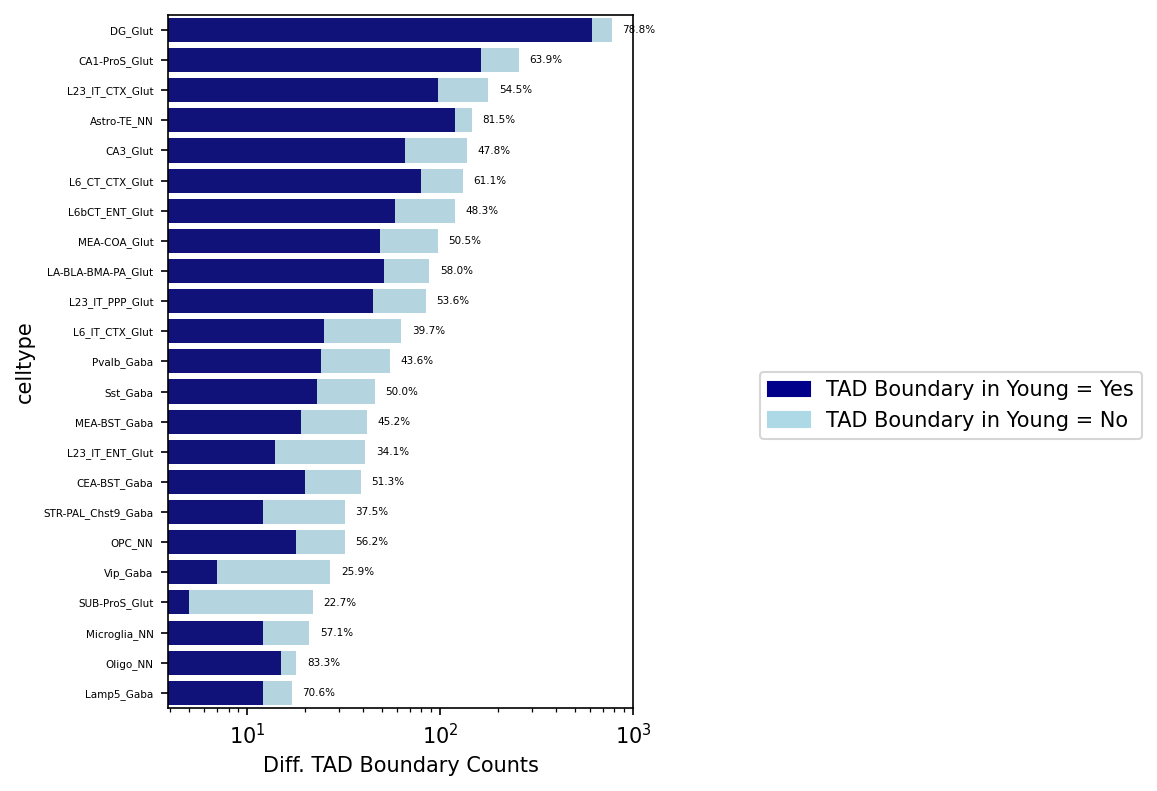

In [15]:
fig, ax = plt.subplots(figsize = (4,6), dpi = 150, constrained_layout = True)
bar1 = sns.barplot(y="celltype",  x="count", ax= ax, data=cell_counts, color='lightblue')
bar2 = sns.barplot(y="celltype",  x="is_bounray_at_young", ax= ax, data=cell_counts, color='darkblue')

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 5)
    
top_bar = mpatches.Patch(color='darkblue', label='TAD Boundary in Young = Yes')
bottom_bar = mpatches.Patch(color='lightblue', label='TAD Boundary in Young = No')
plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor = (1.25,0.5))
ax.set_xlabel('Diff. TAD Boundary Counts')

for p, percent in zip(ax.patches, cell_counts['percent']):
    ax.annotate(f'{percent}%', (p.get_width(), p.get_y() + p.get_height()/2), 
                xytext=(5, 0),  # 5 points horizontal offset
                textcoords='offset points', 
                va='center', ha='left',fontsize = 5)
ax.set_xscale('log')
ax.set_xlim(0, 1000)
#fig.savefig(f"figure/Barplot.DiffBoundary.Celltype.pdf", bbox_inches = 'tight')

## color by cell class

In [16]:
cell_counts['Class'] = cell_counts['celltype'].apply(lambda x: x.split('_')[-1])

In [20]:
cell_counts[cell_counts['Class'] == 'Glut']['count'].sum()

1994

In [22]:
cell_counts['count'].sum()

2469

In [23]:
1994/2469

0.8076144187930336

In [17]:
class_palette = get_cell_class_palette()
class_palette

{'Gaba': '#0000FF',
 'Glut': '#FFA500',
 'NN': '#006400',
 'Glut-Sero': '#FF0000',
 'PAG-PCG': '#00FFFF',
 'IMN': '#800080',
 'Dopa': '#FF00FF'}

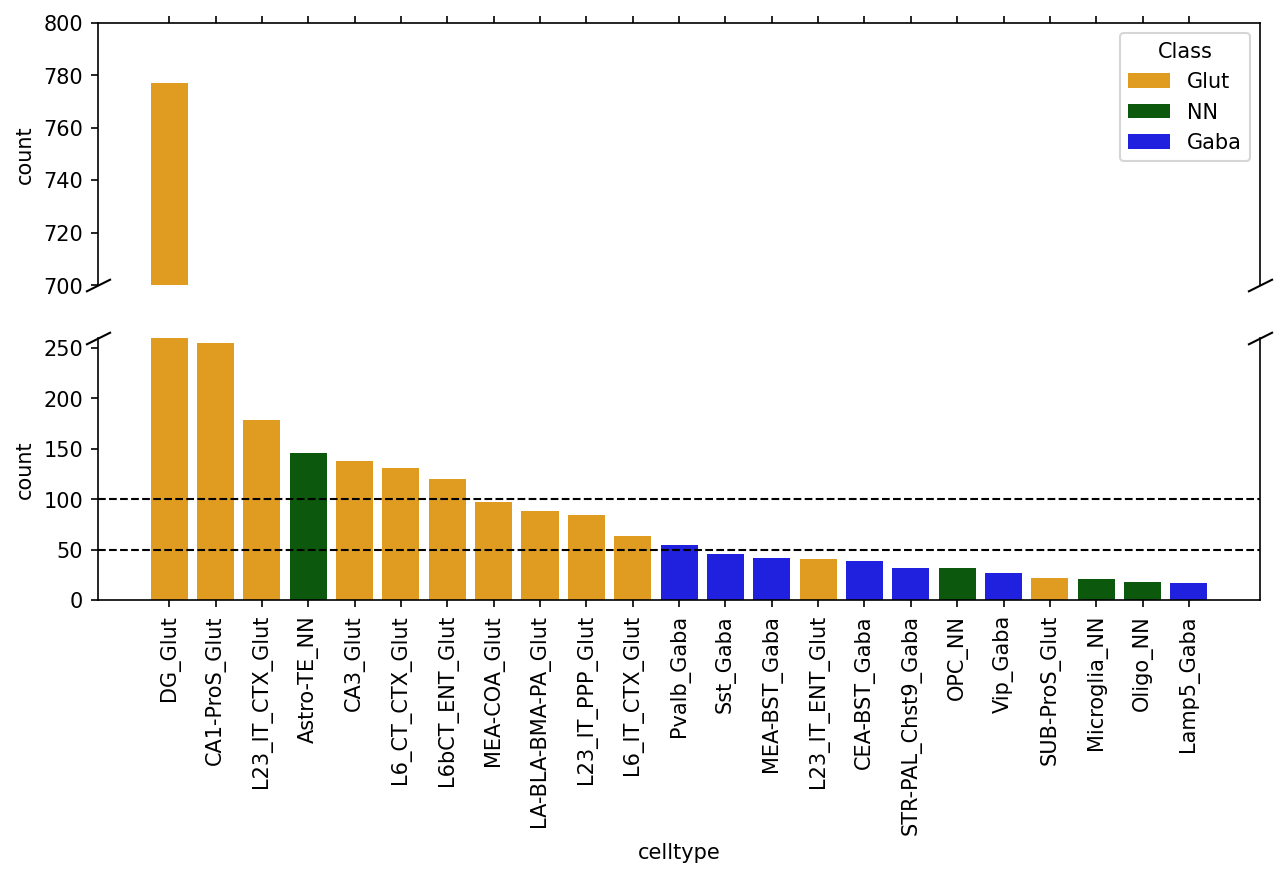

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,5),dpi = 150, sharex=True)

sns.barplot(x='celltype', 
            y="count", 
            hue = 'Class',
            palette = class_palette,
            data = cell_counts,
            ax = ax1,
           dodge=False)

sns.barplot(x='celltype', 
            y="count", 
            hue = 'Class',
            palette = class_palette,
            data = cell_counts,
            ax = ax2,
           dodge=False)
ax2.get_legend().remove()

ax1.set_ylim(700, 800)  # outliers only
ax2.set_ylim(0,260)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.axhline(y = 50, ls = '--', c = 'black', lw = 1)
ax2.axhline(y = 100, ls = '--', c = 'black', lw = 1)
#ax2.axhline(y = 150, ls = '--', c = 'black', lw = 1)

# ax1.set_xticks([])
# ax1.set_xticklabels([])
# ax2.set_xticks([])
# ax2.set_xticklabels([])


plt.xticks(rotation=90)

fig.savefig(f"figure/age-diff-boundary.count.pdf", bbox_inches = 'tight')
plt.show()

In [1]:
!pwd

/home/qzeng_salk_edu/project/240522_fig4_plots
